## About the Dataset

**The data contain estimates of the percentage of body fat determined by underwater weighing and various body circumference measurements for 252 men.**

**Accurate measurement of body fat is inconvenient/costly and it is desirable to have easy methods of estimating body fat that are not inconvenient/costly.**

**The data would be used to produce the predictive equations for lean body weight**

## Metadata Table

Variables      | Types    | Scale     | Length| Description
-------------- | ------   | -------   | ----- | -----------
Case           |Num       | Continous |   8  | Case Number
PctBodyFat1    |Num       | Continous |   8  | Percent body fat using Brozek's equation: 457/Density-414.2
PctBodyFat2    |Num       | Continous |   8  | Percent body fat using Siri's equation: 495/Density-450
Density        |Num       | Continous |   8   | Density (gm/cm^3)
Age            |Num       | Continous |   8   | Age (yrs)
Weight         |Num       | Continous |   8   | Weight (lbs)
Height         |Num       | Continous |   8   | Height (inches)
Adiposity      |Num       | Continous |   8   | Adiposity index = Weight/Height^2 (kg/m^2)
Neck           |Num       | Continous |   8   | Neck circumference (cm)
Chest          |Num       | Continous |   8   | Chest circumference (cm)
Abdomen        |Num       | Continous |   8   | Abdomen circumference (cm)
Hip            |Num       | Continous |   8   | Hip circumference (cm)
Thigh          |Num       | Continous |   8   | Thigh circumference (cm)
Knee           |Num       | Continous |   8   | Knee circumference (cm)    
Ankle          |Num       | Continous |   8   | Ankle circumference (cm)
Biceps         |Num       | Continous |   8   | Biceps circumference (cm)
Forearm        |Num       | Continous |   8   | Forearms circumference (cm)
Wrist          |Num       | Continous |   8   | Wrist circumference (cm)
FatFreeWt      |Num       | Continous |   8   | Fat Free Weight =(1­fraction of body fat)*Weight, using Brozek's

In [ ]:
libname Pfolio '/folders/myfolders/Assign1';

In [5]:
title 'First 10 observations';
Proc print data=pfolio.bodyfat (obs=5);
run;


Obs,Case,PctBodyFat1,PctBodyFat2,Density,Age,Weight,Height,Adioposity,FatFreeWt,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
1,1,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
2,2,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
3,3,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
4,4,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
5,5,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


#### Summary Statistics 

In [13]:
title 'Descriptive Statistics';
ods noproctitle;
Proc means data=pfolio.bodyfat
n nmiss min mean stddev kurt skew p99 max;
var PctBodyFat2	Density	Age	Weight	Height	Adioposity	FatFreeWt	
Neck	Chest	Abdomen	Hip	Thigh	Knee	Ankle	Biceps	Forearm	Wrist;
run;

Variable,Label,N,N Miss,Minimum,Mean,Std Dev,Kurtosis,Skewness,99th Pctl,Maximum
PctBodyFat2 Density Age Weight Height Adioposity FatFreeWt Neck Chest Abdomen Hip Thigh Knee Ankle Biceps Forearm Wrist,Percent Body Fat (method 2) gm / cm^3 yrs lbs inches Weight / Height^2 Fat Free Weight (lbs) cm cm cm cm cm cm cm cm cm cm,252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0.9950000 22.0000000 118.5000000 64.0000000 18.1000000 105.9000000 31.1000000 79.3000000 69.4000000 85.0000000 47.2000000 33.0000000 19.1000000 24.8000000 21.0000000 15.8000000,19.1507937 1.0555738 44.8849206 178.9244048 70.3075397 25.4369048 143.7138889 37.9920635 100.8242063 92.5559524 99.9047619 59.4059524 38.5904762 23.1023810 32.2734127 28.6638889 18.2297619,8.3687404 0.0190314 12.6020397 29.3891599 2.6095829 3.6481108 18.2316416 2.4309132 8.4304755 10.7830768 7.1640577 5.2499520 2.4118046 1.6948934 3.0212738 2.0206912 0.9335849,-0.3338114 -0.3096191 -0.4164409 5.2695136 -0.4039182 6.7124851 2.6567261 2.7196151 0.9872822 2.2488238 7.4713521 2.6657145 1.0615359 11.9451944 0.4984983 0.8663094 0.3956775,0.1463531 -0.0201757 0.2835211 1.2052629 0.1026216 1.5617023 0.9612186 0.5526199 0.6815557 0.8384179 1.4971273 0.8212096 0.5167440 2.2551343 0.2855300 -0.2193328 0.2816139,38.1000000 1.0983000 72.0000000 247.2500000 76.0000000 37.6000000 195.3000000 43.2000000 121.6000000 122.1000000 116.1000000 72.9000000 45.0000000 29.6000000 38.5000000 33.7000000 20.9000000,47.5000000 1.1089000 81.0000000 363.1500000 77.7500000 48.9000000 240.5000000 51.2000000 136.2000000 148.1000000 147.7000000 87.3000000 49.1000000 33.9000000 45.0000000 34.9000000 21.4000000


1. The above table indicates that there are no missing values
2. Comparing 99th percentile to the maximum value, it can be inferred that weight, adioposity, abdomen, chest, fatfreewt and hip might have some outlier cases, which needs further investigation as they might effect the effectiveness of our model

**Target Variable Distribution**


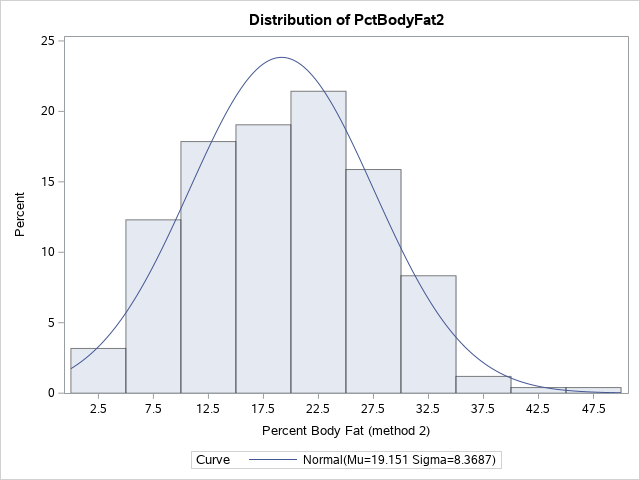
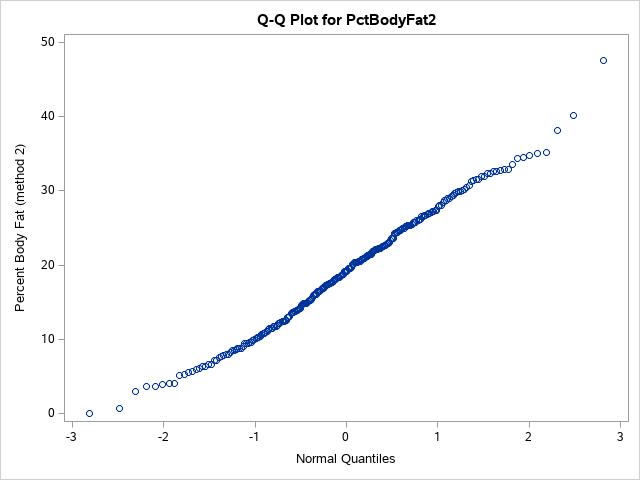

In [17]:
Ods noproctitle;
Ods select histogram qqplot;
Proc univariate data=pfolio.bodyfat;
var PctBodyFat2;
histogram PctBodyFat2 / normal;
qqplot PctBodyFat2;
run;

Visually, histogram look normally distributed and slight positive skewness could be because of the outliers that were noticed above - which needs further investigation


**Outliers Investigation**

In [27]:
title 'Case 39 is a outlier as it is the heaviest case in the dataset';
proc sort data=pfolio.bodyfat;
by case weight height;
proc print data=pfolio.bodyfat (firstobs=20 obs=40);      
var case age height weight;
title;

Obs,Case,Age,Height,Weight
20,20,33,73.50,211.75
21,21,28,68.00,179.00
22,22,28,69.75,200.50
23,23,31,68.25,140.25
24,24,32,70.00,148.75
25,25,28,67.75,151.25
26,26,27,71.50,159.25
27,27,34,67.50,131.50
28,28,31,67.50,148.00
29,29,27,64.75,133.25


­ Case 39 has the highest weight and other body measurements like abdomen, chest, fatfreeweight and neck which can be connected back to our individual exploration of all these variables where they showed signs of presence of anolmalies

In [ ]:
data bodyfat7;
set pfolio.bodyfat;
new_pctbodyfat2 = 495/Density - 450;
run;

In [ ]:
Proc sort data = bodyfat7;
by case;
run;

In [29]:
proc print data = bodyfat7;
where case in (48, 76, 96, 182);
var case PctBodyFat2 new_pctbodyfat2;
run;

Obs,Case,PctBodyFat2,new_pctbodyfat2
48,48,5.6,14.1350
76,76,18.5,14.0915
96,96,17.4,0.3685
182,182,0.0,-3.6117


Cases 48, 76, 96, 182  are calculated wrong in the dataset according to Siri body fat percentage formula. This explains the importance of data integrity. Also, according to the Siri Formulla, case 182 has negative pctbodyfat, which is unusal - hence we can consider it as an unsual observation.


#### Histogram for percentage body fat (with right Siri calculations)


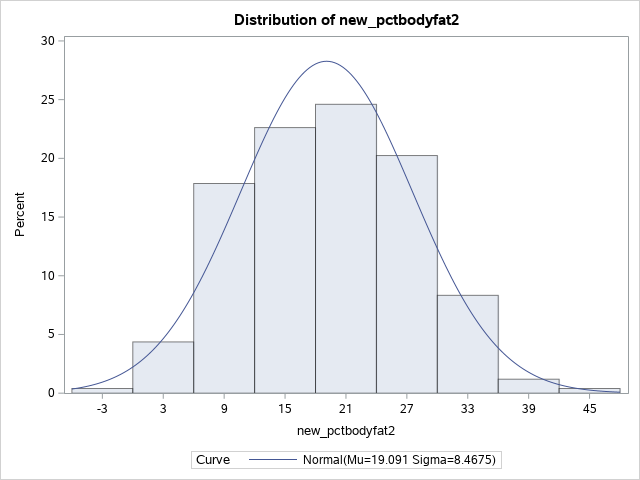

In [31]:
ods select histogram;
Proc univariate data=bodyfat7;      /* Actual Siri calculation distribuion */
var new_pctbodyfat2 ;
histogram new_pctbodyfat2 / normal;
run;

The histogram for the new percentage bodyfat calculation according to Siri formulla visually looks more normally distributed, hence it can be concluded that the abnormal distribution was due to the wrong calculation


### Bi-variate analysis

**FatFreeWeight, Density, PctBodyweight1 can be removed from our analysis as target variable can be mathematically calculated using their formulla. Also, case can be dropped as it doesn't hold any significance**

#### Correlation check

In [33]:
/* Corrlinearity check  */
ods select  PearsonCorr;
proc corr data=pfolio.bodyfat;
var age weight height adioposity 
neck chest abdomen hip thigh knee 
ankle biceps forearm wrist;
run;


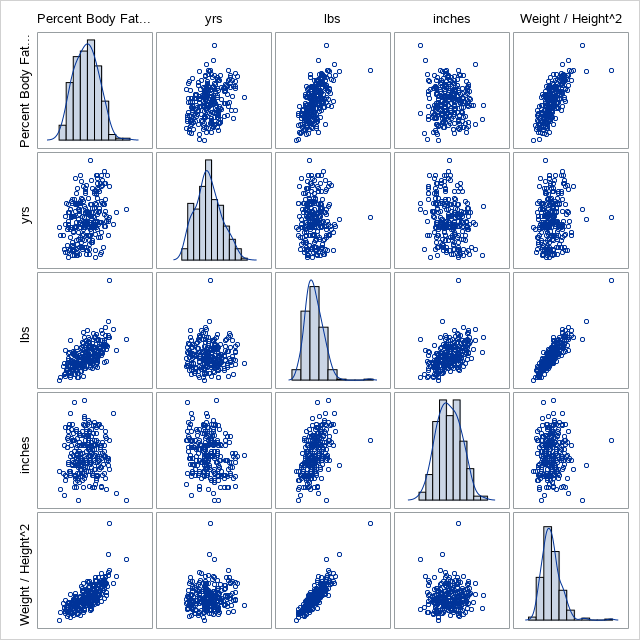

In [40]:
proc sgscatter data=pfolio.bodyfat;
matrix pctbodyfat2 age weight height
adioposity / diagonal=(histogram kernel);
run;


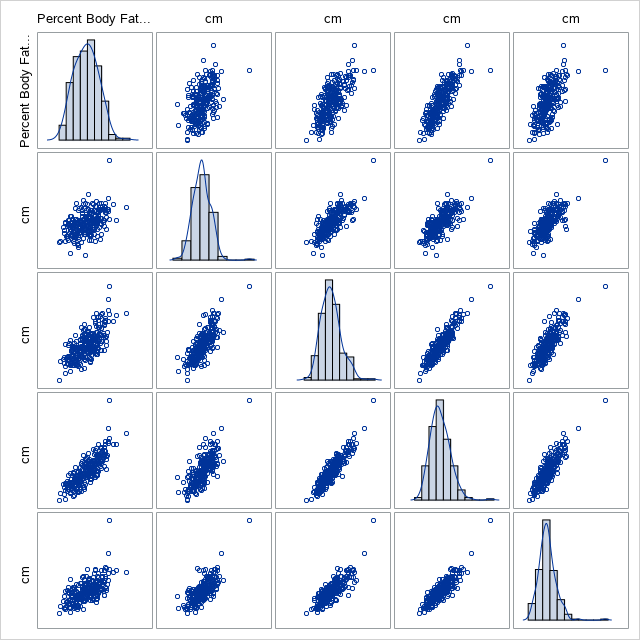

In [39]:
proc sgscatter data=pfolio.bodyfat;
matrix pctbodyfat2 Neck  Chest  Abdomen Hip/ diagonal=(histogram kernel);
run;


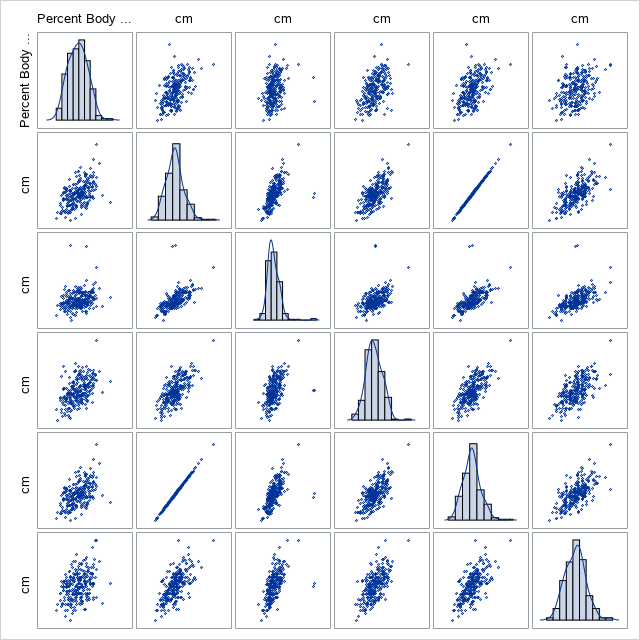

In [38]:
proc sgscatter data=pfolio.bodyfat;
matrix pctbodyfat2 knee ankle biceps knee wrist / diagonal=(histogram kernel);
run;

The above graphs and correaltion table indicates that there are serveral variables in our dataset that have a positive linear relationship with our target variable

### Base Linear Regression Model with all the variables 

1. H0 = There is no relatioship target and predictors. Slope = 0 i.e it's a flat line model
2. Ha = There is relationship between the target and predictors i.e. slope is not equal to 0
3. The model must explain relationship between PctbodyFat2 and various body measurements
4. Also, before building a model, it is imperative to build a foundation and make sure there is no multi-collinearity effect. Variation inflation factor (VIF) and eigenvalues can be used to detect any multi-collinearity

In [43]:
ods select nobs anova fitstatistics parameterestimates collindiag;
proc reg data=pfolio.bodyfat;
model pctbodyfat2 = weight age adioposity height neck
chest abdomen hip thigh knee ankle biceps forearm wrist
/ ss2 influence partial r collin tol vif stb;
run;
quit;

First weight and then adioposity was dropped, considering their high variation inflation factor and collinearity diagnostic table, which suggests multi collinearity. Both the variables can be easily explained using other variables. Also, it can be noticed that VIF values of most of the variables dropped significantly after removing these variables.

1. R square - 0.7497
2. Adj R square - 0.7349


In [48]:
ods select nobs anova fitstatistics parameterestimates collindiag;
proc reg data=pfolio.bodyfat;
model pctbodyfat2 = age height neck
chest abdomen hip thigh knee ankle biceps forearm wrist
/ ss2 influence partial r stb;
run;
quit;

#### Backward Selection

In [50]:
ods graphics on / width = 7.5in height = 6.6in;
ods select nobs anova fitstatistics parameterestimates;
proc reg data=pfolio.bodyfat;
model pctbodyfat2 = age height neck chest abdomen thigh 
knee ankle biceps forearm wrist
/ ss2 influence partial r vif stb
selection = backward;
run; 
quit;

- R square - 0.7371
- Adj R square - 0.7370

Backward selection resulted in all sigificant variables that can be further used in our final model. Although, intercept is insignificant. 

#### Dropping Intercept - possible final model


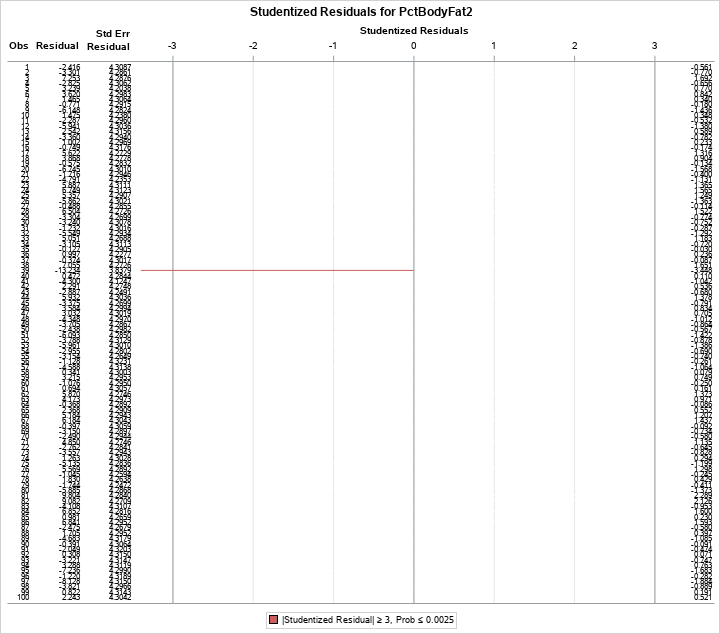
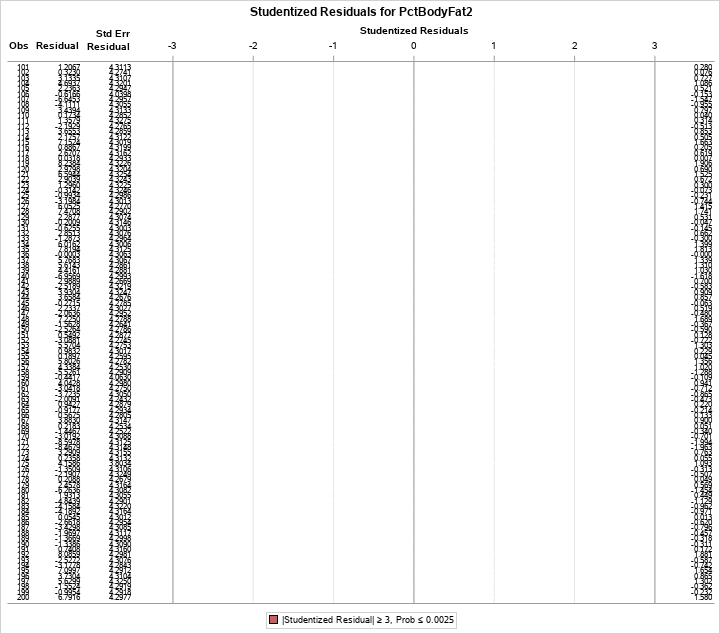
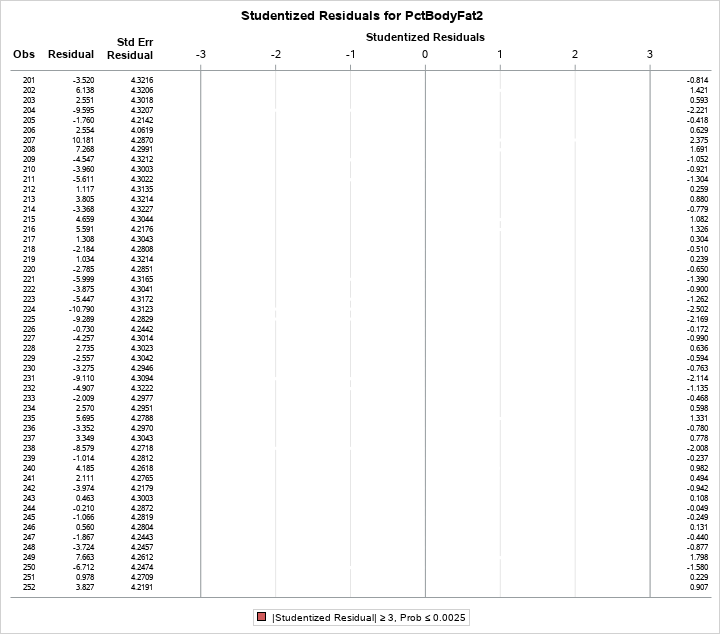
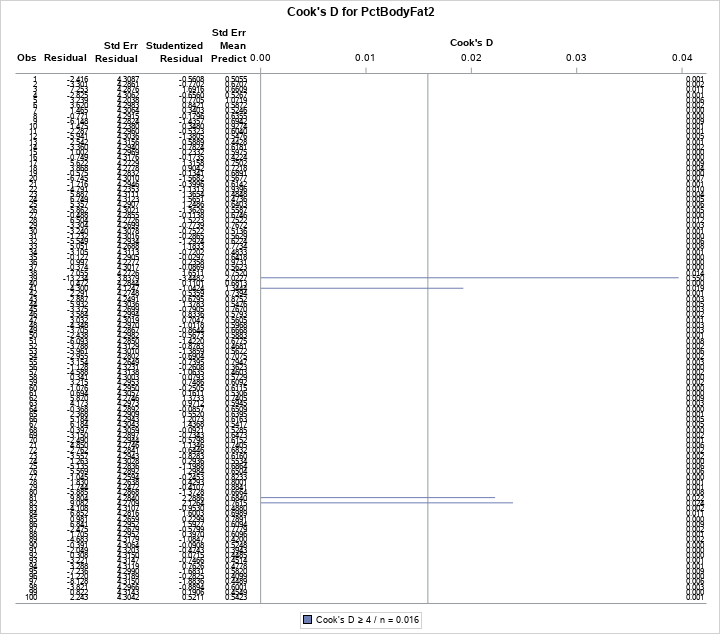
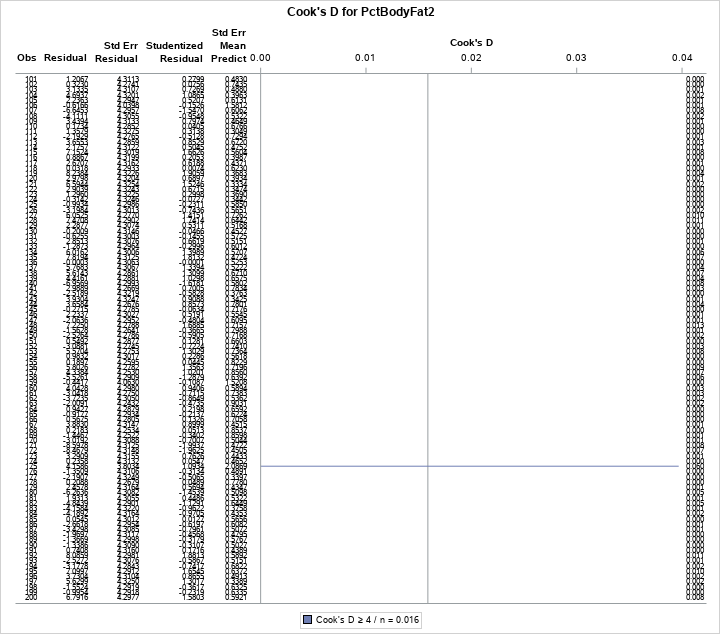
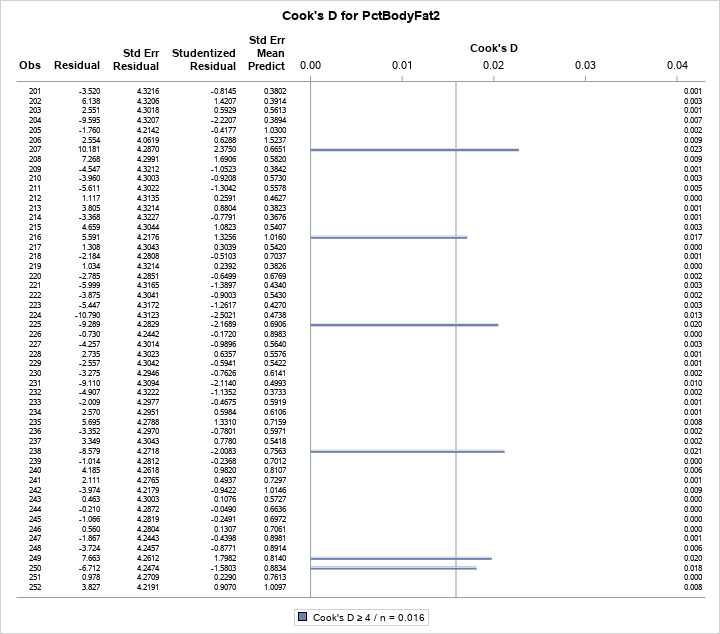
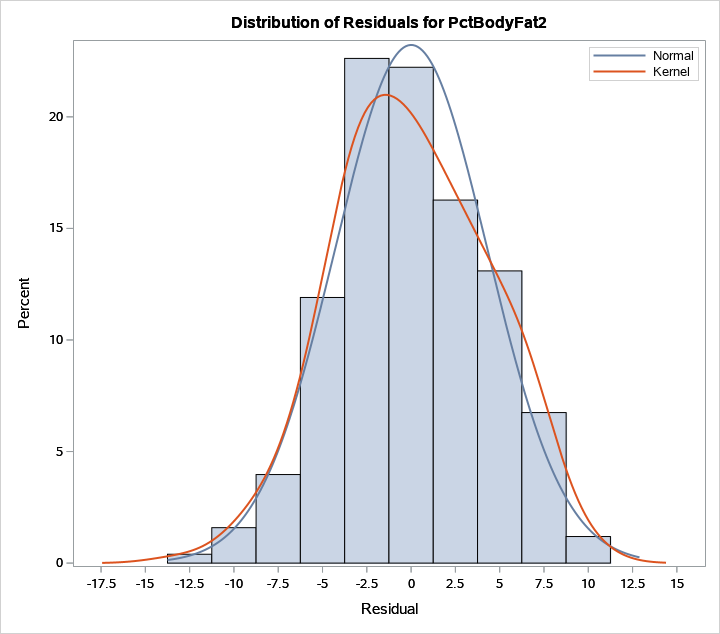
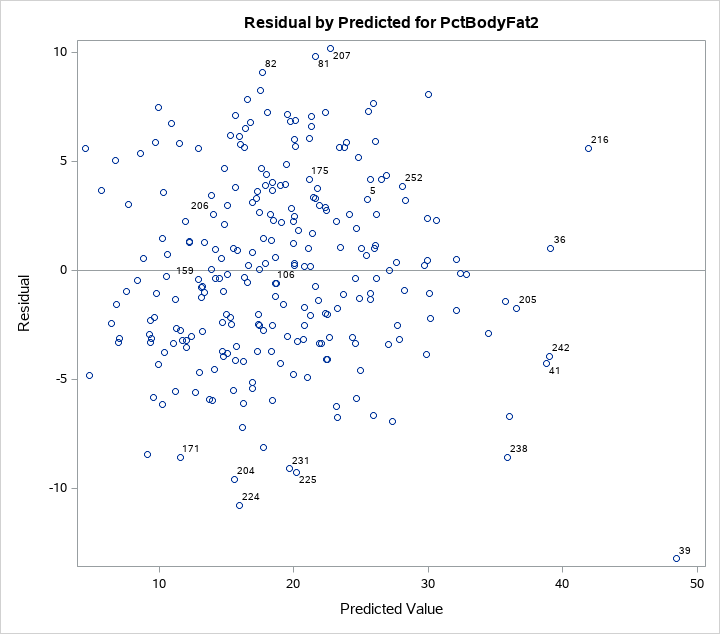
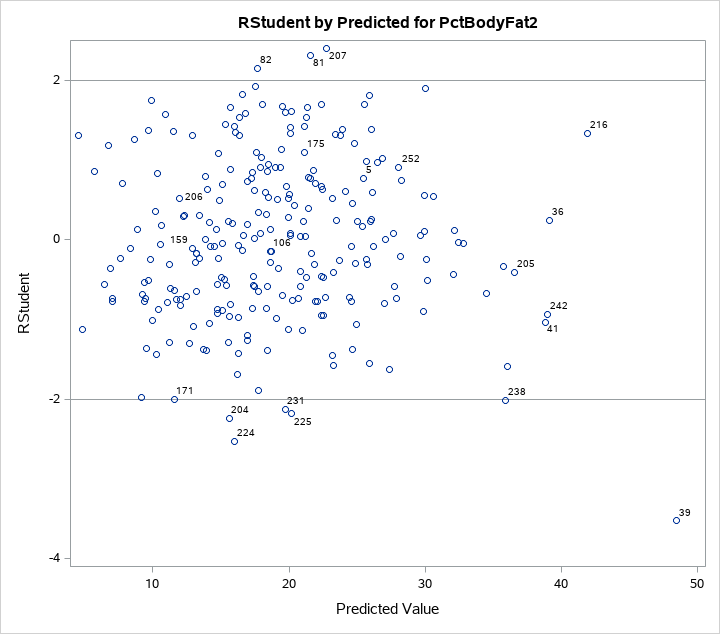
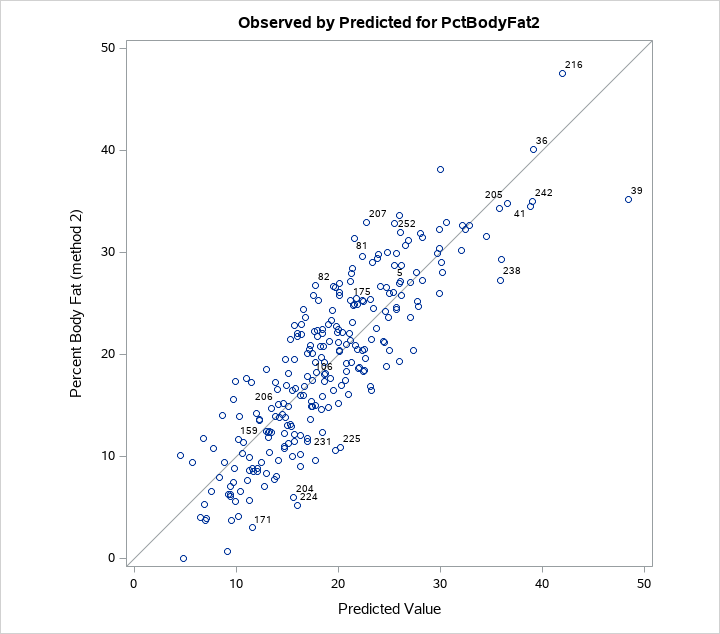
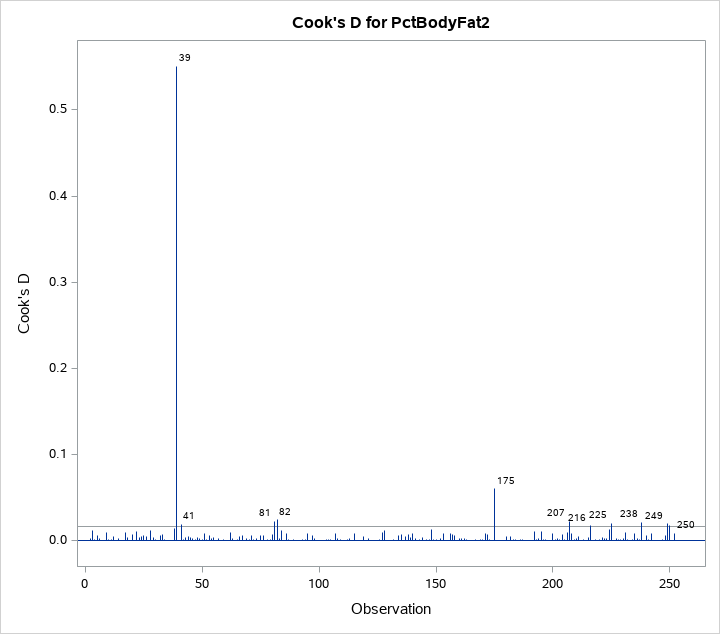
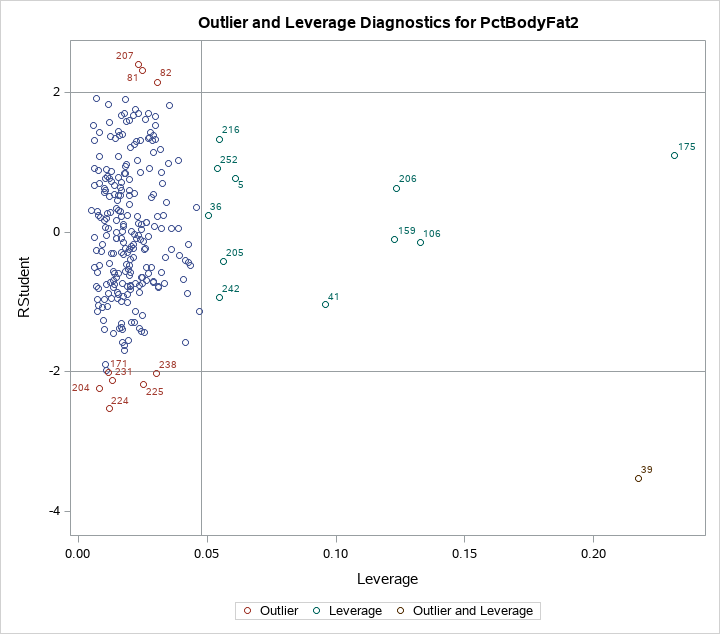
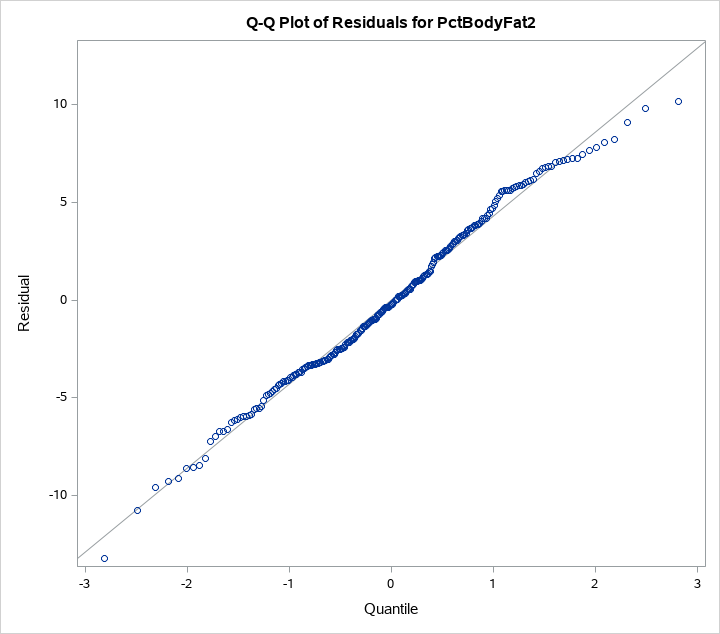
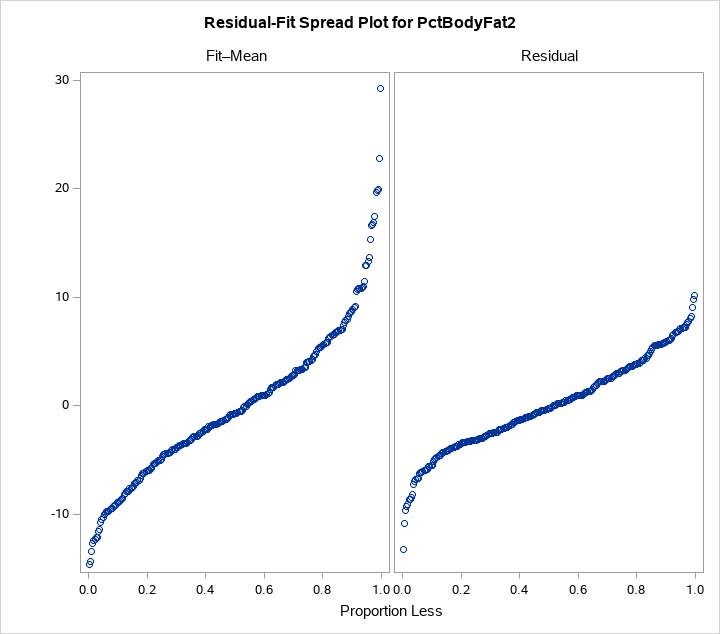
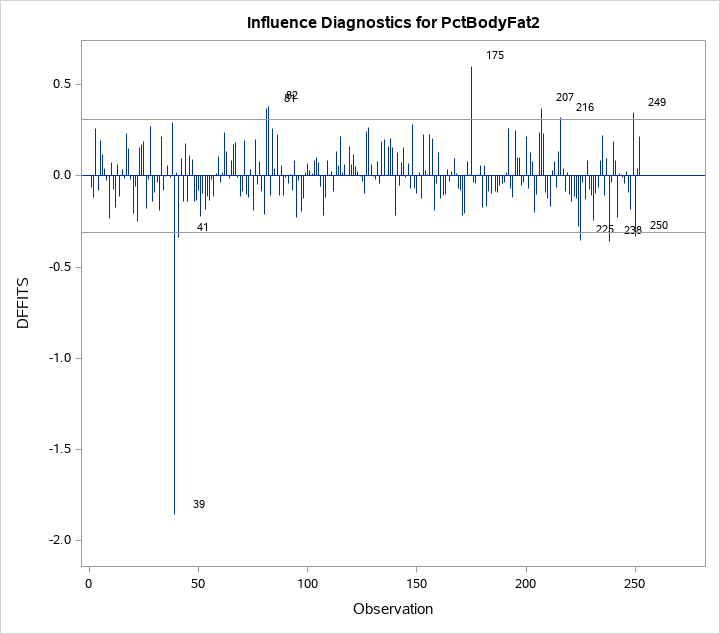
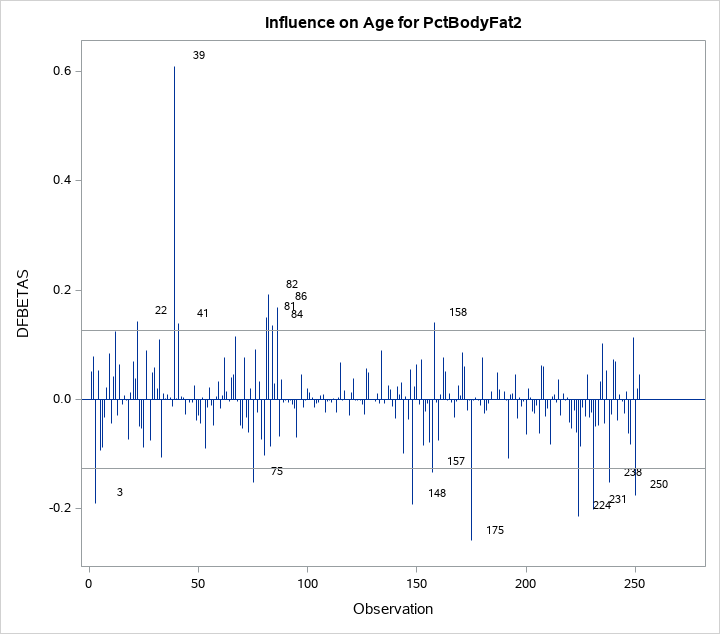
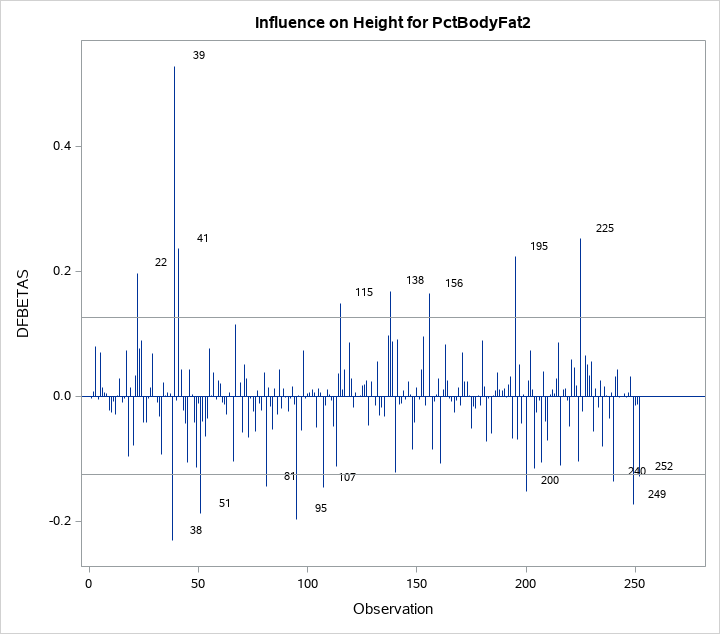
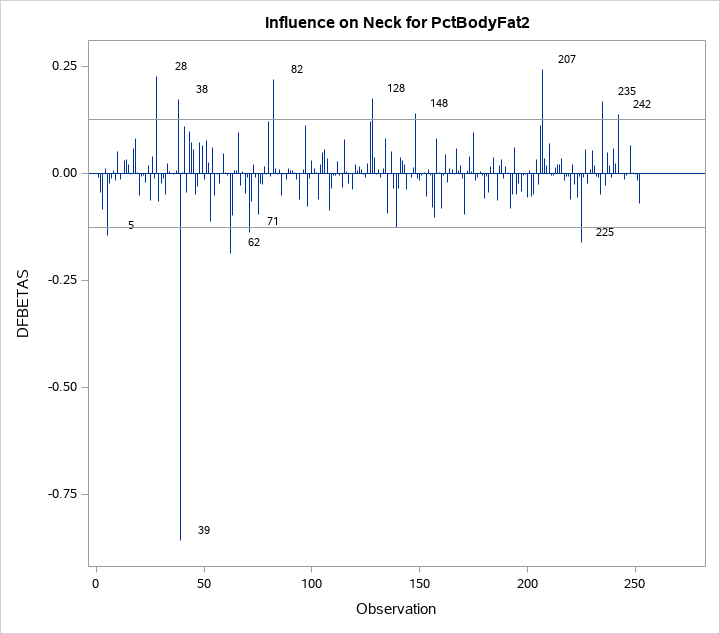
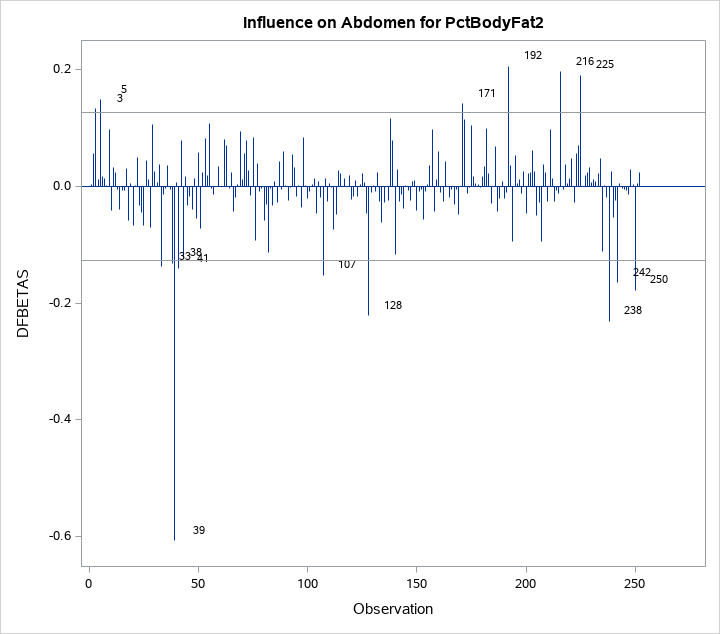
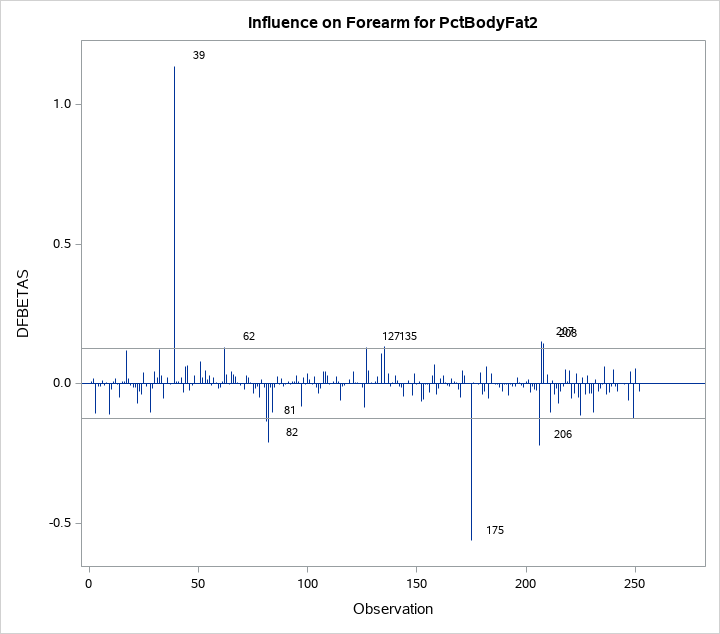
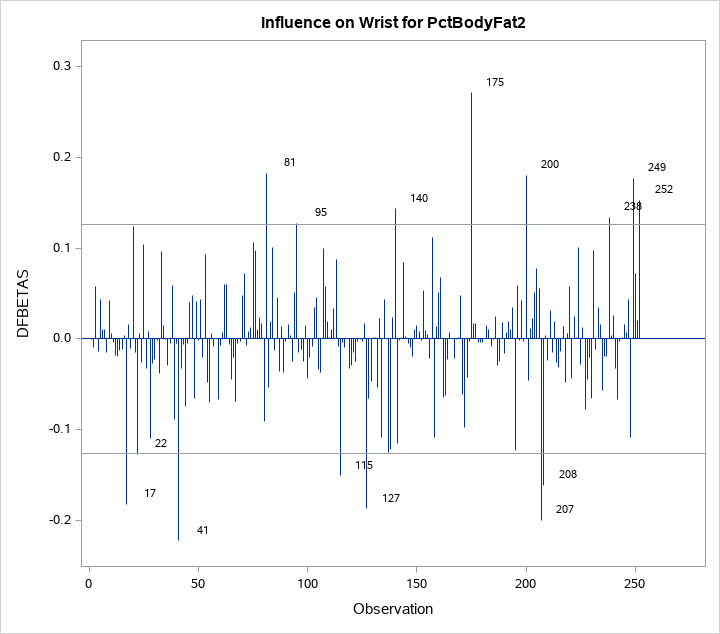
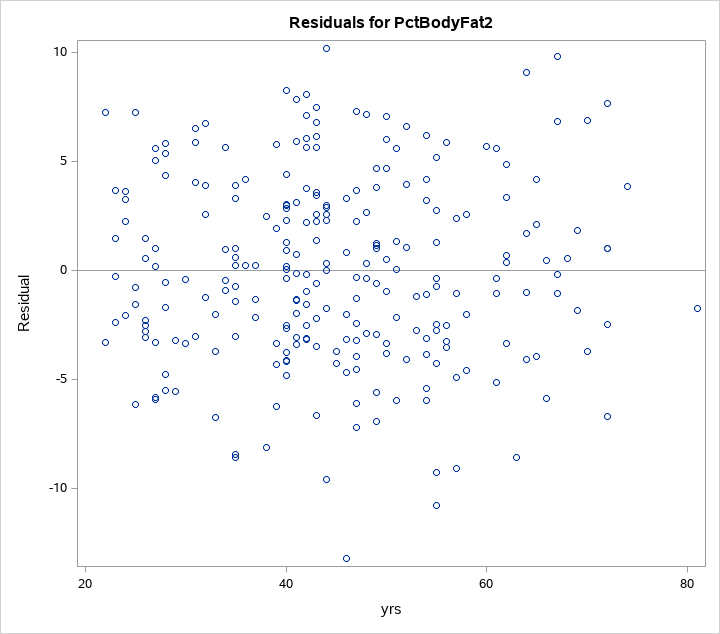
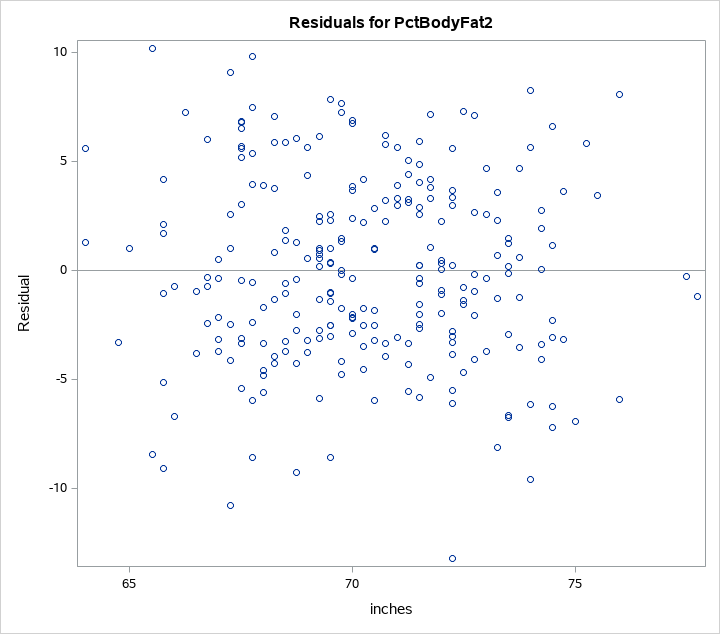
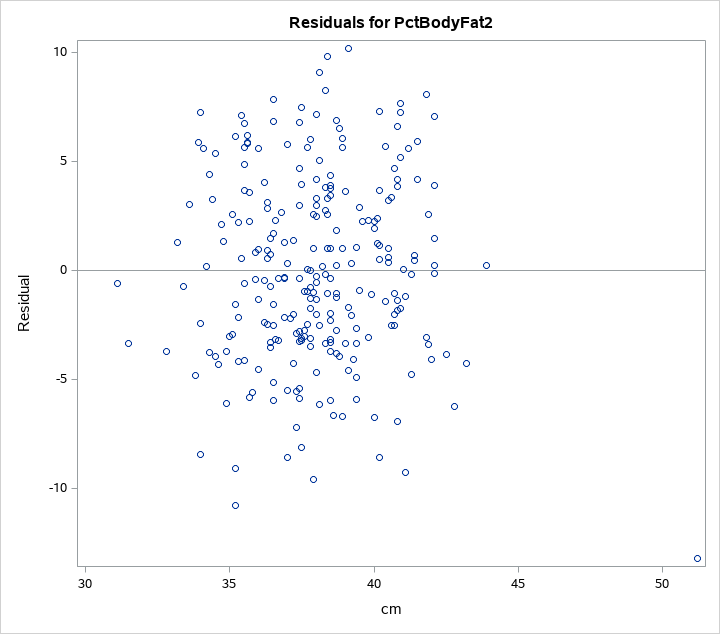
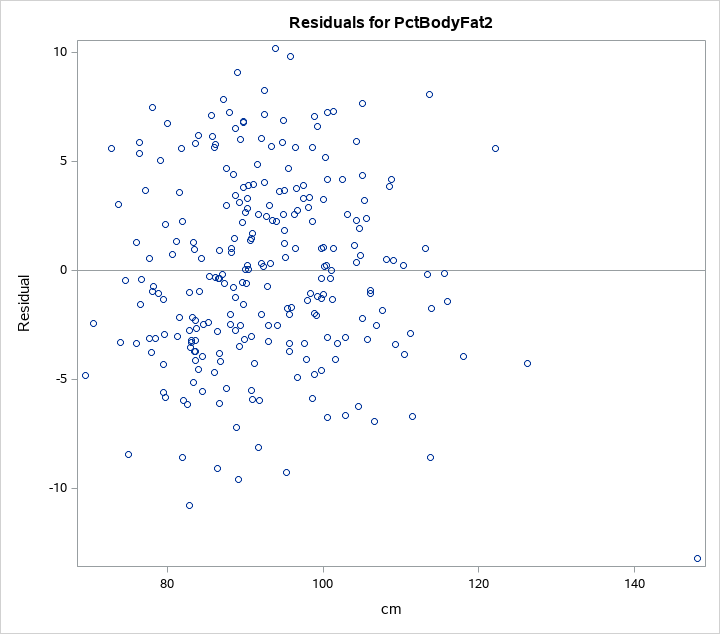
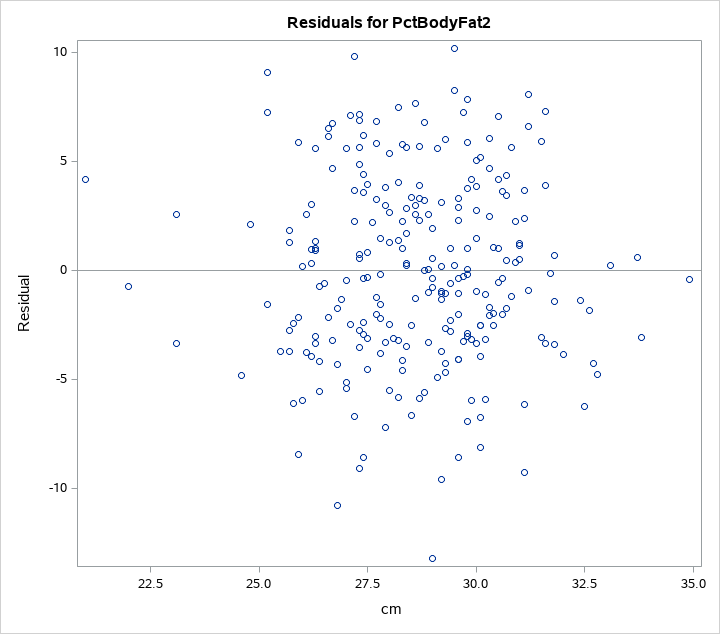
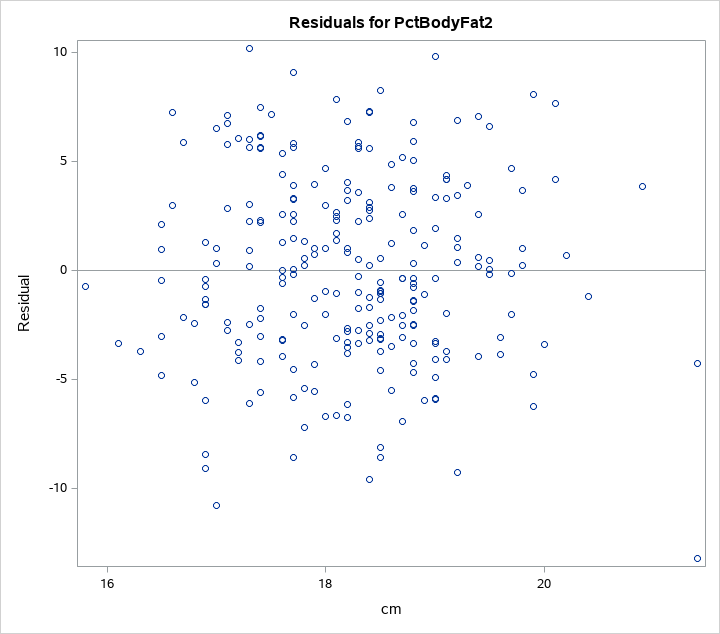
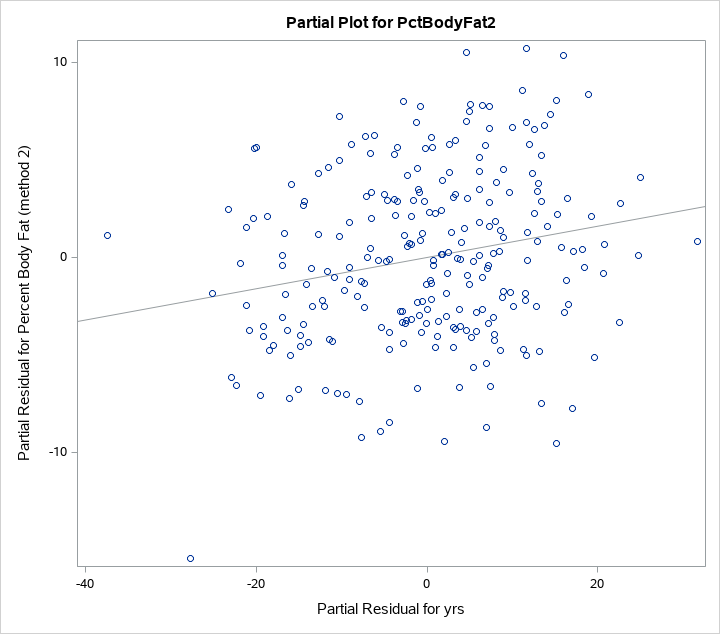
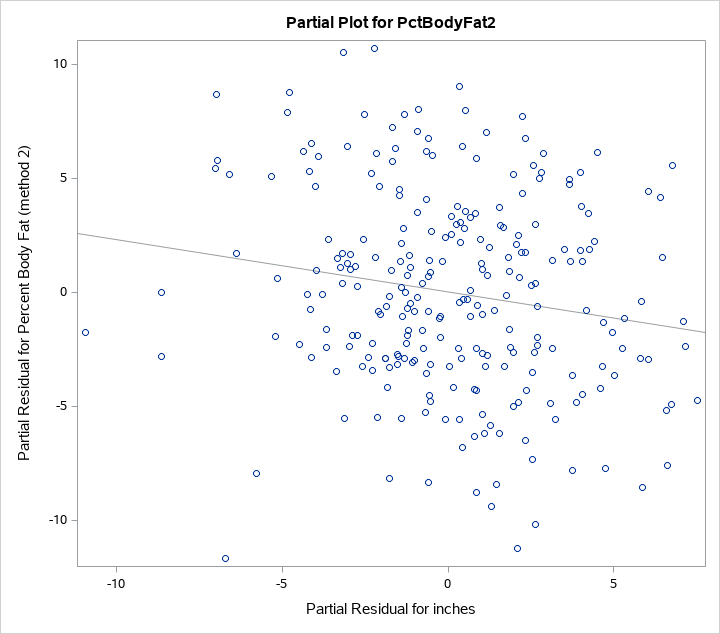
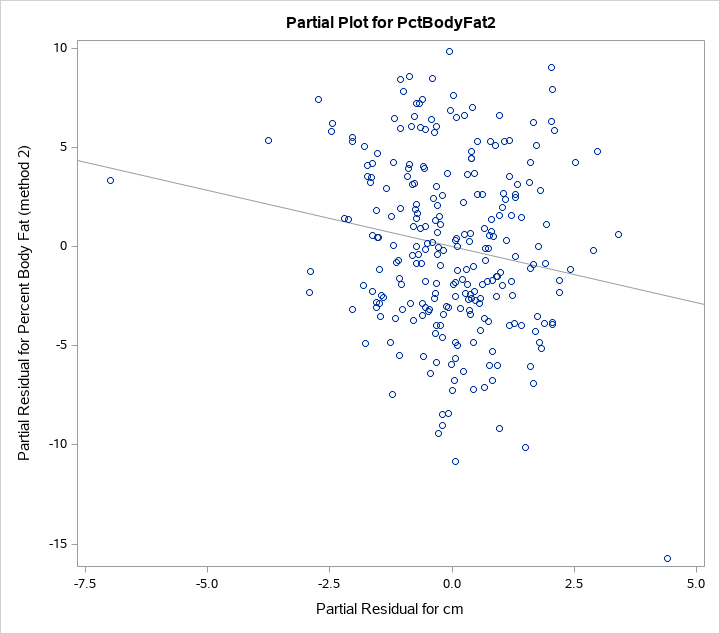
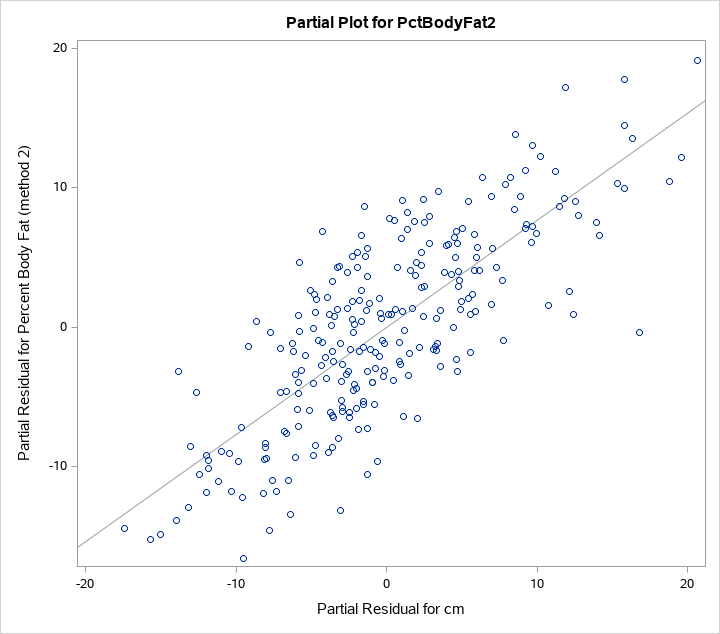
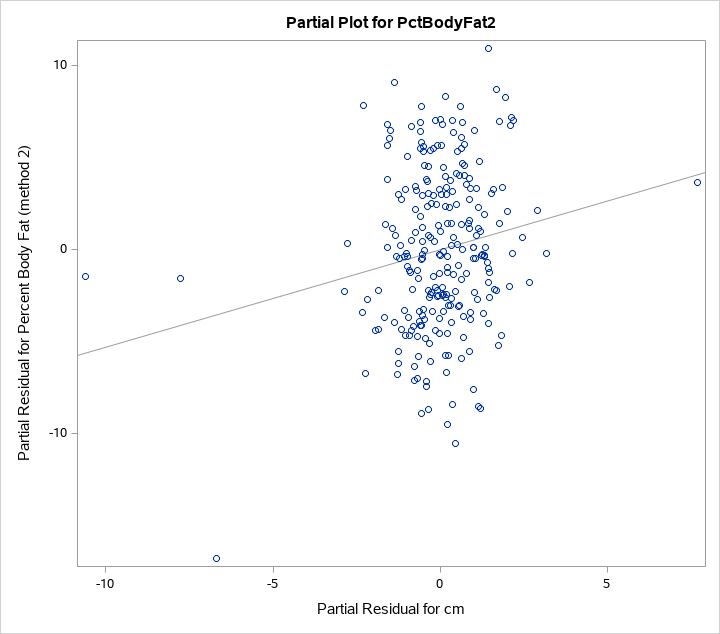
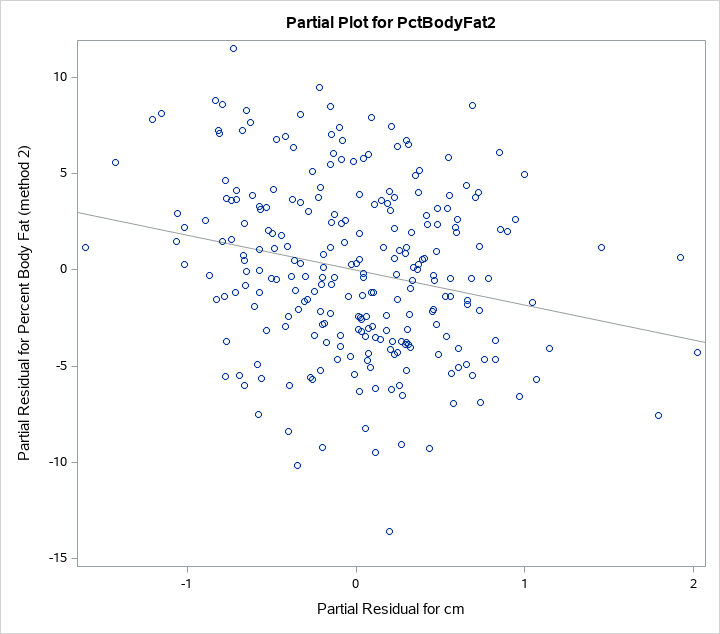

In [51]:
ods exclude OutputStatistics;
proc reg data=pfolio.bodyfat
plots(maxpoints=none label unpack) = (diagnostics dffits dfbetas);
model pctbodyfat2 = age height neck abdomen 
forearm wrist / noint ss2 influence partial r stb;
run; 
quit;

On dropping intercept, R square and adj R square increased to:

- R square - 0.9595
- Adj R square - 0.9585

i.e. 95% of the variation can be explained using this model. Although, both DFBETAS and Cooks D chart indicates an outlier (case 39). It's imerative to find out if removing this outlier improves the efficiency the model


****Removing case 39 did not result in any model efficiency**

- There are 6 significant variables - Age, height, neck, abdomen, wrist and forearm
- Abdomen has the highest Type II SS (7028.54) value which indicates that it is the most important variable


**Visual Diagnostic**

- Both Residual distribution plot and residual qq plot are normally distributed
- The visual check of ObservedByPredicted graph has a diagonal line, which indicates that the model works
- Also in the residual Fit spread plot, the centred fitted values is taller than the residual values, which also concludes that spread of residual values is smaller than spread of the fitted values


**Model Equation**
The above model can be expressed using equation:

pctbodyfat2 = 

        +Age(0.08045) 
        +Abdomen(0.76907) 
        -Height(0.22919) 
        -Neck(0.56594) 
        -Wrist(1.82180) 
        +Forearm(0.52952)